In [1]:
import os
import numpy as np
from astropy.table import Table, Column, join
import matplotlib.pyplot as plt
from astropy import units as u
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.xy2hist import xy2hist
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Spatially resolved SF relations for EDGE, at 7" resolution.

In [2]:
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
          'flux_sigsfr_sm','EW_Halpha_sm','ZOH_sm','BPT_sm']

try: 
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'flux_sigsfr_sm', 'EW_Halpha_sm', 'ZOH_sm', 'BPT_sm', 'mass_ssp_sm', 'sigstar_sm', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'sigmol', 'e_sigmol']


In [4]:
# Apply a 3-sigma cut to both axes
det = (fluxtab['mom0']>3*fluxtab['emom0']) & (fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm'])
codata = fluxtab['mom0'][det]
hadata = fluxtab['flux_Halpha_sm'][det]
sig_mol = fluxtab['sigmol'][det]
sig_sfr = fluxtab['flux_sigsfr_sm'][det]
sig_star = fluxtab['sigstar_sm'][det]

# Ratios
t_dep = Column(sig_mol.quantity/sig_sfr.quantity, name='t_dep')
sig_ssfr = Column(sig_sfr.quantity/sig_star.quantity, name='sig_ssfr')

Table([sig_mol,sig_sfr,t_dep,sig_star,sig_ssfr]).pprint(max_width=100)

    sigmol       flux_sigsfr_sm      t_dep      sigstar_sm    sig_ssfr  
solMass / pc2 solMass / (Gyr pc2)     Gyr     solMass / pc2   1 / Gyr   
------------- ------------------- ----------- ------------- ------------
     69.41965            4264.703 0.016277721     153.65915    27.754307
    117.74085           1659.4858   0.0709502     226.68369    7.3207116
    182.01974           283.81058  0.64134234     348.42795     0.814546
    182.47313           81.362434   2.2427197     403.99884   0.20139274
     99.05433           37.264805   2.6581202     338.16318    0.1101977
    11.304429          0.22132742   51.075592     48.072304 0.0046040528
    112.55416           2584.3906 0.043551527     237.23666   10.8937235
    392.45047           2706.2402  0.14501686     433.47876    6.2430744
    770.36115           3947.4978  0.19515176     609.88837     6.472492
     721.5256            905.9145    0.796461      645.6331    1.4031413
          ...                 ...         ...      

In [5]:
# Derived quantities for the CO non-detections
ndet = (fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm']) & ~det
# Upper limits need to be calculated explicitly since e_sigmol is only the uncertainty for detections
sig_mol_ndet = msd_co(3*fluxtab['emom0max'][ndet], name='sig_mol_ul')
sig_sfr_ndet = fluxtab['flux_sigsfr_sm'][ndet]
sig_star_ndet = fluxtab['sigstar_sm'][ndet]

# Ratios
t_dep_ndet = Column(sig_mol_ndet.quantity/sig_sfr_ndet.quantity, name='t_dep_ul')
sig_ssfr_ndet = Column(sig_sfr_ndet.quantity/sig_star_ndet.quantity, name='sig_ssfr_ndet')

Table([sig_mol_ndet,sig_sfr_ndet,t_dep_ndet,sig_star_ndet,sig_ssfr_ndet]).pprint(max_width=100)

  sig_mol_ul     flux_sigsfr_sm     t_dep_ul    sigstar_sm  sig_ssfr_ndet
solMass / pc2 solMass / (Gyr pc2)     Gyr     solMass / pc2    1 / Gyr   
------------- ------------------- ----------- ------------- -------------
    17.945454           2.3511002   7.6327896     14.411152     0.1631445
    17.982803           3.0608351   5.8751297     14.411152     0.2123935
     17.13626           0.9160764   18.706146     14.786302   0.061954398
    16.999317           0.8049302   21.118996     14.411152   0.055854674
    16.949522           1.6174102   10.479421     14.411152    0.11223324
    16.980644           2.3877137   7.1116753     14.411152    0.16568513
    17.105137           1.3400556   12.764498           nan           nan
    16.482677          0.49096203   33.572205     12.094206   0.040594812
    16.277267           2.6172721   6.2191725     11.024177    0.23741204
    16.146551           1.4531318   11.111553     14.411152    0.10083384
          ...                 ...     

## Spatially resolved CO vs. Halpha

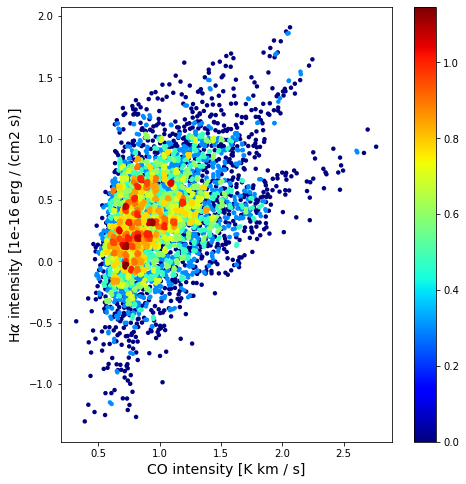

In [6]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(codata, hadata, log=True)
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
plt.xlabel('CO intensity ['+str(codata.unit)+']',fontsize=14)
plt.ylabel(r'H$\alpha$ intensity ['+str(hadata.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)

## Spatially resolved star formation law (extinction corrected)

Excluding 9 invalid values
Number of valid points: 4796


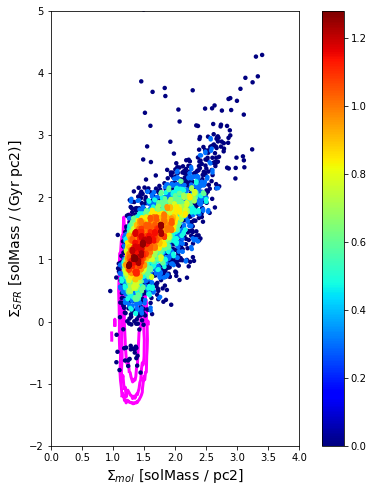

In [7]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_mol)) & (~np.isnan(sig_sfr)) & (sig_mol>0) & (sig_sfr>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))
not_nan_ndet = (~np.isnan(sig_mol_ndet)) & (~np.isnan(sig_sfr_ndet)) & (sig_mol_ndet>0) & (sig_sfr_ndet>0)

x_det, y_det, z_det, *hist = xy2hist(sig_mol[not_nan], sig_sfr[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_mol_ndet[not_nan_ndet], 
                                         sig_sfr_ndet[not_nan_ndet], log=True, bins=[50,50])

# Make the scatter plot (physical values)
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'$\Sigma_{mol}$ ['+str(sig_mol.unit)+']',fontsize=14)
plt.ylabel(r'$\Sigma_{SFR}$ ['+str(sig_sfr.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0,4)
ax.set_ylim(-2,5)
plt.colorbar(sc)

## Depletion time vs. local stellar density

Excluding 10 invalid values
Number of valid points: 4795


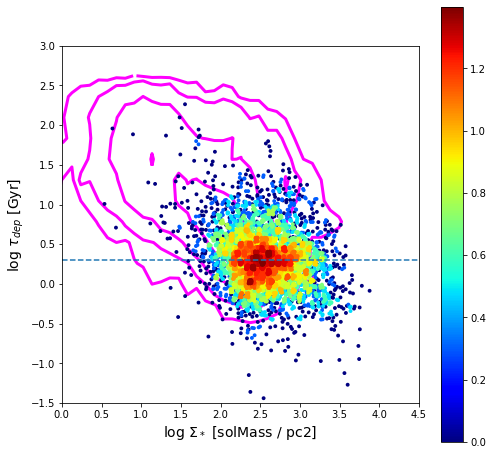

In [8]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))
not_nan_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)

x_det, y_det, z_det, *hist = xy2hist(sig_star[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], log=True, bins=[50,50])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)

## Depletion time vs. local sSFR

Excluding 10 invalid values
Number of valid points: 4795


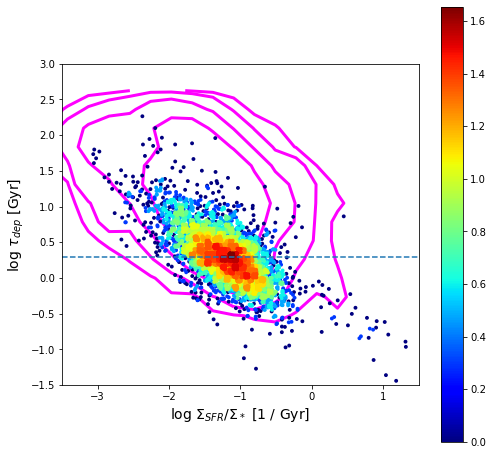

In [9]:
# Select data to plot (must be loggable)
not_nan = (np.isfinite(sig_ssfr)) & (np.isfinite(t_dep)) & (sig_ssfr>0) & (t_dep>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))
not_nan_ndet = (np.isfinite(sig_ssfr_ndet)) & (np.isfinite(t_dep_ndet)) & (sig_ssfr_ndet>0) & (t_dep_ndet>0)

x_det, y_det, z_det, *hist = xy2hist(sig_ssfr[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_ssfr_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], log=True, bins=[50,50])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sig_ssfr.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)